*Copyright (c) Cornac Authors. All rights reserved.*

*Licensed under the Apache 2.0 License.*

# Model Ensembling

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/cornac/blob/master/tutorials/model_ensembling.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/cornac/blob/master/tutorials/model_ensembling.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This notebook provides an example of how to ensemble multiple recommendation models in Cornac.

Ensemble models is a technique that combines the predictions of multiple models to produce a single prediction. The idea is that by combining the predictions of multiple models, we can improve the overall performance of the recommendation system.

We will use the MovieLens 100K dataset and ensemble 2 models.

** Note: ** This notebook requires the `scikit-learn` package. 

## 1. Setup

### Install required dependencies

In [1]:
! pip install seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.1 MB/s eta 0:00:00


In [51]:
import numpy as np
import pandas as pd
import seaborn as sns

from cornac.datasets import movielens
from cornac.data import Dataset
from cornac.models import BPR, WMF

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

## 2. Prepare Experiment

### Loading Dataset

First, we load the MovieLens 100K dataset.

In [52]:
data = movielens.load_feedback(variant="100K") # load dataset
dataset = Dataset.from_uir(data) # convert to Dataset object

### Training BPR and WMF models

We will train two models: 

1. BPR (Bayesian Personalized Ranking)
2. WMF (Weighted Matrix Factorization)

In [53]:
# Train BPR model
bpr_model = BPR(k=10, max_iter=100, learning_rate=0.01, lambda_reg=0.001)
bpr_model.fit(dataset)

# Train WMF model
wmf_model = WMF(k=10, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,)
wmf_model.fit(dataset)

100%|██████████| 100/100 [00:04<00:00, 23.59it/s, loss=107]  


Learning completed!


### Reviewing Individual Trained Models

These models are trained and evaluated individually. The scores of the models will be used to ensemble the models.

Let's see what the prediction scores of user index 0 looks like.
Take note that user index '0' may not correspond to user ID '0', depending on how the dataset is loaded.

This prints scores of all items for user index 0. The higher the score, the more likely the user will like the item.

In [54]:
# get item ids scores
print("BPR scores for user idx 0:", bpr_model.score(0)) # get BPR scores of user idx 0
print("WMF scores for user idx 0:", wmf_model.score(0)) # get WMF scores of user idx 0

BPR scores for user idx 0: [ 3.1180067  3.2947896 -0.8666828 ... -1.8775543 -2.0990407 -1.9722794]
WMF scores for user idx 0: [3.513375   3.7615533  1.1817346  ... 0.23760092 0.23549344 0.25031105]


## 3. Perform Model Ensembling

Prepare the data for the ensemble model. We will use the predictions of the individual models as features for the ensemble model.

In [55]:
# Get all scores

uidx_list = [0]
# uidx_list = range(dataset.num_users)

scores_bpr = np.array([bpr_model.score(uidx) for uidx in uidx_list])
scores_wmf = np.array([wmf_model.score(uidx) for uidx in uidx_list])

scores_bpr = scores_bpr.flatten()
scores_wmf = scores_wmf.flatten()

print("BPR scores shape:", scores_bpr.shape)
print("WMF scores shape:", scores_wmf.shape)

X_train = np.array(2 * [(uidx, iidx) for iidx in range(dataset.num_items) for uidx in uidx_list])
y_train = np.concatenate((scores_bpr, scores_wmf))

print(X_train.shape, y_train.shape)

BPR scores shape: (1682,)
WMF scores shape: (1682,)
(3364, 2) (3364,)


Next, we train this ensemble model.

We use a bagging ensemble model with a decision tree as the base estimator.



### Training models

In [56]:
base_model = DecisionTreeRegressor(random_state=42)
bagging_model = BaggingRegressor(base_model, n_estimators=10)
adaboost_model = AdaBoostRegressor(base_model, n_estimators=50)

randomforest_model = RandomForestRegressor(n_estimators=200, random_state=42)

# bagging_model.fit(X_train, y_train)
adaboost_model.fit(X_train, y_train)
randomforest_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

## 4. New Model Prediction

### Prediction for a given input

In [57]:
print("Adaboost model - Predict scoring of user index 0, item index 0:", adaboost_model.predict([(0, 0)]))
print("Random Forest model - Predict scoring of user index 0, item index 0:", randomforest_model.predict([(0, 0)]))

adaboost_scores = adaboost_model.predict([(uidx, iidx) for iidx in range(dataset.num_items) for uidx in uidx_list])
randomforest_scores = randomforest_model.predict([(uidx, iidx) for iidx in range(dataset.num_items) for uidx in uidx_list])

Adaboost model - Predict scoring of user index 0, item index 0: [3.11800671]
Random Forest model - Predict scoring of user index 0, item index 0: [3.23781075]


In [58]:
df = pd.DataFrame({
    'itemindex': 4 * [iidx for iidx in range(dataset.num_items) for _ in uidx_list],
    'score': np.concatenate((scores_bpr, scores_wmf, adaboost_scores, randomforest_scores)),
    'model': ['bpr'] * dataset.num_items * len(uidx_list) + ['wmf'] * dataset.num_items * len(uidx_list) + ['adaboost'] * dataset.num_items * len(uidx_list) + ['randomforest'] * dataset.num_items * len(uidx_list),
})

Let's compare the scores of the ensemble model with the individual models.

<Axes: xlabel='itemindex', ylabel='score'>

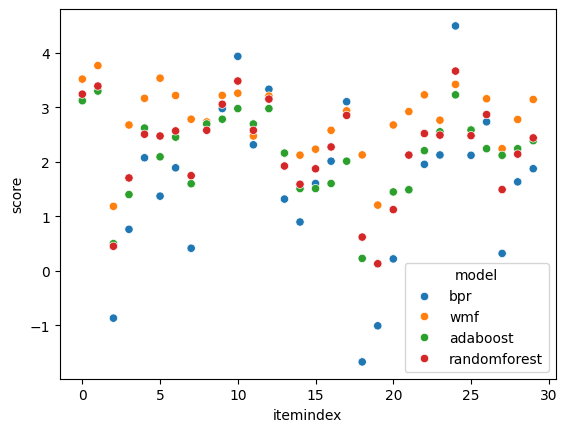

In [59]:
# Get first 30 items and visualize them.
sub_df = df[df['itemindex'] < 30]

sns.scatterplot(x=sub_df['itemindex'], y=sub_df['score'], hue=sub_df['model'])


### Obtaining top N items for each model

#### Using pandas DataFrame

The following code snippet shows how to obtain the top N items for each model using pandas.

Comparing top N items between models. Take note that these are item indexes instead of item IDs.

In [60]:
n = 10

bpr_df = df[df['model'] == 'bpr'].nlargest(n, 'score')

wmf_df = df[df['model'] == 'wmf'].nlargest(n, 'score')

adaboost_df = df[df['model'] == 'adaboost'].nlargest(n, 'score')
print(adaboost_df)

randomforest_df = df[df['model'] == 'randomforest'].nlargest(n, 'score')
print(randomforest_df)

bpr_top_n = bpr_df['itemindex'].values
print("bpr item recommendations:", list(bpr_top_n))
wmf_top_n = wmf_df['itemindex'].values
print("wmf item recommendations:", list(wmf_top_n))
adaboost_top_n = adaboost_df['itemindex'].values
print("adaboost item recommendations:", list(adaboost_top_n))
randomforest_top_n = adaboost_df['itemindex'].values
print("randomforest item recommendations:", list(randomforest_top_n))



      itemindex     score     model
3721        357  3.770982  adaboost
3787        423  3.755059  adaboost
3855        491  3.596724  adaboost
3497        133  3.499176  adaboost
3453         89  3.477541  adaboost
3653        289  3.343402  adaboost
4057        693  3.331351  adaboost
3365          1  3.294790  adaboost
3413         49  3.277095  adaboost
3416         52  3.277095  adaboost
      itemindex     score         model
5403        357  4.019552  randomforest
5135         89  3.839201  randomforest
5095         49  3.831661  randomforest
5335        289  3.817783  randomforest
5098         52  3.806902  randomforest
5537        491  3.738302  randomforest
5646        600  3.695803  randomforest
5070         24  3.660665  randomforest
5203        157  3.606354  randomforest
5367        321  3.538210  randomforest
bpr item recommendations: [357, 600, 89, 491, 289, 24, 423, 49, 52, 83]
wmf item recommendations: [357, 1, 189, 200, 719, 49, 180, 31, 239, 174]
adaboost item recom

To map it back into Item IDs, we use the iid_map which gives us item ID to index mappings.

In [61]:
iid_to_index_list = list(dataset.iid_map.items())

print(iid_to_index_list)

bpr_top_n_iid = [iid_to_index_list[item_idx][0] for item_idx in bpr_top_n]
wmf_top_n_iid = [iid_to_index_list[item_idx][0] for item_idx in wmf_top_n]
adaboost_top_n_iid = [iid_to_index_list[item_idx][0] for item_idx in adaboost_top_n]
randomforest_top_n_iid = [iid_to_index_list[item_idx][0] for item_idx in randomforest_top_n]

print("bpr item recommendations:", bpr_top_n_iid)
print("wmf item recommendations:", wmf_top_n_iid)
print("adaboost item recommendations:", adaboost_top_n_iid)
print("randomforest item recommendations:", randomforest_top_n_iid)

[('242', 0), ('302', 1), ('377', 2), ('51', 3), ('346', 4), ('474', 5), ('265', 6), ('465', 7), ('451', 8), ('86', 9), ('257', 10), ('1014', 11), ('222', 12), ('40', 13), ('29', 14), ('785', 15), ('387', 16), ('274', 17), ('1042', 18), ('1184', 19), ('392', 20), ('486', 21), ('144', 22), ('118', 23), ('1', 24), ('546', 25), ('95', 26), ('768', 27), ('277', 28), ('234', 29), ('246', 30), ('98', 31), ('193', 32), ('88', 33), ('194', 34), ('1081', 35), ('603', 36), ('796', 37), ('32', 38), ('16', 39), ('304', 40), ('979', 41), ('564', 42), ('327', 43), ('201', 44), ('1137', 45), ('241', 46), ('4', 47), ('332', 48), ('100', 49), ('432', 50), ('322', 51), ('181', 52), ('196', 53), ('679', 54), ('384', 55), ('143', 56), ('423', 57), ('515', 58), ('20', 59), ('288', 60), ('219', 61), ('526', 62), ('919', 63), ('26', 64), ('232', 65), ('427', 66), ('512', 67), ('15', 68), ('1049', 69), ('416', 70), ('165', 71), ('690', 72), ('248', 73), ('1444', 74), ('5', 75), ('229', 76), ('237', 77), ('480'